In [215]:

# import libraries
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from nltk.stem.porter import *
from collections import defaultdict
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score,accuracy_score

In [27]:
# nltk.download("all")

In [129]:
# Load the amazon review dataset
df = pd.read_csv('./data/IMDB Dataset.csv')

In [130]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [131]:
df.shape

(50000, 2)

In [163]:
df = df[:10000]

In [148]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
9995,"Fun, entertaining movie about WWII German spy ...",positive
9996,Give me a break. How can anyone say that this ...,negative
9997,This movie is a bad movie. But after watching ...,negative
9998,This is a movie that was probably made to ente...,negative


In [164]:
train, test = train_test_split(df,test_size=0.30, shuffle= True)

In [ ]:
def preprocess_text(text:str):
    
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    tokens = word_tokenize(text.lower())

    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    stemmer =  PorterStemmer()
    
    stopwords_set = set(stopwords.words("english"))
    
    tokens_2 = [stemmer.stem(token) for token in filtered_tokens if token not in stopwords_set]

    return tokens_2

In [165]:
train

,review,sentiment
9787,While it was filmed at a Florida National Guar...,positive
3834,It's boring.<br /><br />It's slow.<br /><br />...,negative
7986,All Boris Karloff fans will love this classic ...,positive
1263,A Vow to Cherish is a wonderful movie. It's ba...,positive
5854,This very funny British comedy shows what migh...,positive
...,...,...
7024,STAR RATING: ***** The Works **** Just Misses ...,positive
730,This is the Who at their most powerful. Althou...,positive
8577,"This film has ""haunted"" me since I saw it when...",positive
5907,i'm watching this horrid film as we speak. it ...,negative


In [ ]:
def calculate_word_counts(reviews):
    word_count = defaultdict(int)
    
    for review in reviews:
        tokens = preprocess_text(review)
        
        for token in tokens:
            word_count[token] += 1
    
    return word_count

In [ ]:
def calculate_likelihood(word_count, total_words, laplacian_smoothing=1):
    likelihood = {}
    
    vocabulary_size = len(word_count)

    for word, count in word_count.items():
        likelihood[word] = (count + laplacian_smoothing) / (total_words + laplacian_smoothing * vocabulary_size)

    # Return the calculated likelihood dictionary
    return likelihood

In [ ]:
def calculate_log_prior(sentiment, data):
    return math.log(len(data[data['sentiment'] == sentiment]) / len(data))

In [169]:
def classify_review_with_scores(review, log_likelihood_positive, log_likelihood_negative,log_prior_positive, log_prior_negative):
    tokens = preprocess_text(review)

    log_score_positive = log_prior_positive + sum([log_likelihood_positive.get(token, 0) for token in tokens])
    log_score_negative = log_prior_negative + sum([log_likelihood_negative.get(token, 0) for token in tokens])

    sentiment_scores = {
        'positive': log_score_positive,
        'negative': log_score_negative
    }

    predicted_sentiment = max(sentiment_scores, key=sentiment_scores.get)
    return predicted_sentiment, sentiment_scores

In [167]:
word_count_positive = calculate_word_counts(train[train['sentiment'] == 'positive']['review'])
word_count_negative = calculate_word_counts(train[train['sentiment'] == 'negative']['review'])

total_positive_words = sum(word_count_positive.values())
total_negative_words = sum(word_count_negative.values())

likelihood_positive = calculate_likelihood(word_count_positive, total_positive_words)
likelihood_negative = calculate_likelihood(word_count_negative, total_negative_words)

positive = calculate_log_prior('positive', train)
negative = calculate_log_prior('negative', train)

log_likelihood_positive = {word: math.log(prob) for word, prob in likelihood_positive.items()}
log_likelihood_negative = {word: math.log(prob) for word, prob in likelihood_negative.items()}

In [ ]:
correct_predictions = 0
total_predictions = len(test)
y_pred = []

for index, row in test.iterrows():
    predicted_sentiment, sentiment_scores = classify_review_with_scores(
        row['review'], log_likelihood_positive, log_likelihood_negative,
        positive, negative,
    )
    y_pred.append(predicted_sentiment)

In [172]:
test['sentiment']

8896    negative
276     negative
749     positive
5811    negative
1680    negative
          ...   
8758    positive
5330    negative
9896    negative
2144    negative
3621    negative
Name: sentiment, Length: 3000, dtype: object

In [205]:
len(y_pred)

3000

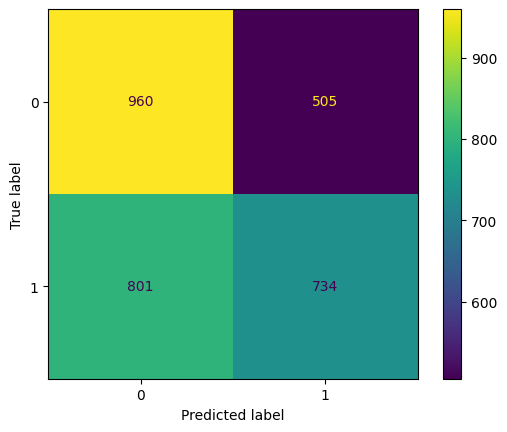

In [206]:
confusion_matr = confusion_matrix(test['sentiment'], y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matr, display_labels = [0, 1])

cm_display.plot()
plt.show() 

In [ ]:
accuracy_score(test['sentiment'], y_pred)

0.5687790202848095

In [222]:
precision_score(test['sentiment'], y_pred,average='macro')

0.5687790202848095